# Results Optiwise deviation points

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys

import paper
from phd.visualization.styles import styles
from vessel_manoeuvring_models.KF_multiple_sensors import interpolate_and_insert_all
from phd.visualization.units import units
from phd.visualization.symbols import symbols
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored
from phd.pipelines.regression_VCT.nodes import subtract_centripetal_and_Coriolis
import matplotlib.ticker as plticker
from phd.pipelines.filter.nodes import lowpass
from vessel_manoeuvring_models.data.lowpass_filter import lowpass_filter
from phd.load_data import acc

In [3]:
ship_name = "optiwise"

In [4]:
model = catalog.load(f"{ship_name}.models_VCT_MDL")['semiempirical_covered_inertia']()

[01/02/25 15:41:09] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=702456;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=728862;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/__ ]8;id=782513;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=411626;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             init__.py:44: KedroDeprecationWarning: 'AbstractDataSet' has been                     
                             renamed to 'AbstractDataset', and the alias will be removed in Kedro                  
                             0.19.0                                                                                
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Loading data from 'optiwise.models_VCT_MDL'                        ]8;id=662238;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=870865;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [5]:
meta_datas = catalog.load(f"{ship_name}.test_meta_data")

meta_datas = meta_datas.groupby('test_type').get_group('zigzag')
mask = meta_datas['ship_speed'] > 0.9
meta_datas = meta_datas.loc[mask].copy()

[01/02/25 15:41:12] INFO     Loading data from 'optiwise.test_meta_data' (CSVDataSet)...        ]8;id=216564;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=422302;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [6]:
mask = meta_datas['angle']==-10

In [7]:
meta_datas_select = meta_datas.loc[mask]

In [8]:
dataframes = {}

for id,row in meta_datas_select.iterrows():

    test = catalog.load(f"{ship_name}.tests")[str(id)]()
    test = lowpass(test, cutoff=1)
    dataframes[f'{id} (lowpass)'] = model.forces_from_motions(test).iloc[0:-100]
    

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=282473;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=578258;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=168417;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=508389;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    WARNING  /home/maa/dev/PHD/src/phd/pipelines/filter/nodes.py:395:               ]8;id=158138;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=948351;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_lowpass.iloc[skip_samples:-skip_samples][key] = df.iloc[                         
                                                                                                                   

                    WARNING  /home/maa/dev/PHD/src/phd/pipelines/filter/nodes.py:414:               ]8;id=57957;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=100160;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_lowpass.iloc[skip_samples:-skip_samples][key] = df.iloc[                         
                                                                                                                   

[01/02/25 15:41:13] INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=281221;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=415865;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    WARNING  /home/maa/dev/PHD/src/phd/pipelines/filter/nodes.py:395:               ]8;id=994228;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=88042;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_lowpass.iloc[skip_samples:-skip_samples][key] = df.iloc[                         
                                                                                                                   

                    WARNING  /home/maa/dev/PHD/src/phd/pipelines/filter/nodes.py:414:               ]8;id=339258;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=164731;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_lowpass.iloc[skip_samples:-skip_samples][key] = df.iloc[                         
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=598153;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=161895;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    WARNING  /home/maa/dev/PHD/src/phd/pipelines/filter/nodes.py:395:               ]8;id=693095;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=996913;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_lowpass.iloc[skip_samples:-skip_samples][key] = df.iloc[                         
                                                                                                                   

                    WARNING  /home/maa/dev/PHD/src/phd/pipelines/filter/nodes.py:414:               ]8;id=560804;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=102252;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_lowpass.iloc[skip_samples:-skip_samples][key] = df.iloc[                         
                                                                                                                   

In [9]:
id = 23590
df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
dataframes[f'{id} (EKF)'] = model.forces_from_motions(df_EKF_smooth).iloc[0:-100]
styles={
    f'{id} (EKF)' : {'style':'k-','zorder':100, 'lw':1},
}

[01/02/25 15:41:14] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=351807;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=104005;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=68152;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=706300;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

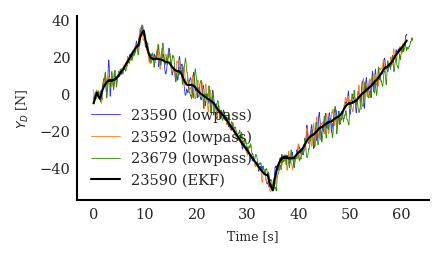

In [18]:
fig = plot(dataframes, keys=['Y_D'], ncols=1, styles=styles, units=units);
fig.axes[0].grid(False)
fig.set_size_inches(paper.figure_width*0.5,0.5*paper.figure_height)

paper.save_fig(fig,"lowpass.svg")

In [11]:
def filter(s:pd.Series, cutoff=10, order=1, btype='low'):
    ts = s.index[1] - s.index[0]
    fs = 1/ts
    return lowpass_filter(s, fs=fs, cutoff=cutoff, order=order, btype=btype)

In [12]:
def filter_keys(df:pd.DataFrame, keys=[], cutoff=10, order=1, btype='low'):

    df_filtered = df.copy()
    
    for key in keys:
        df_filtered[key] = filter(df[key], cutoff=cutoff, order=order, btype=btype)

    return df_filtered

In [13]:
keys = ['Hull/Acc/X1','Hull/Acc/Y1','Hull/Acc/Y2','Hull/Acc/Z1','Hull/Acc/Z2','Hull/Acc/Z3']
test_lowpass = filter_keys(df=test, keys=keys, cutoff=0.5, order=1)

In [14]:
point1 = {
'x_P': 1.435,
'y_P': 0.0,
'z_P': -0.499,
}

point2 = {
    'x_P': -1.420,
    'y_P': 0.282,
    'z_P': -0.499,
}

point3 = {
    'x_P': -1.420,
    'y_P': -0.282,
    'z_P': -0.499,
}

In [15]:
acceleration = acc(
    xacc1=test_lowpass['Hull/Acc/X1'],
    yacc1=test_lowpass['Hull/Acc/Y1'],
    yacc2=test_lowpass['Hull/Acc/Y2'],
    zacc1=test_lowpass['Hull/Acc/Z1'],
    zacc2=test_lowpass['Hull/Acc/Z2'],
    zacc3=test_lowpass['Hull/Acc/Z3'],
    xco=0,
    yco=0,
    zco=0,
    point1=point1,
    point2=point2,
    point3=point3,
   )
    

In [16]:
df_acc = pd.DataFrame(acceleration.T, columns=['u1d','v1d','r1d'], index=test.index)

<Axes: xlabel='time'>

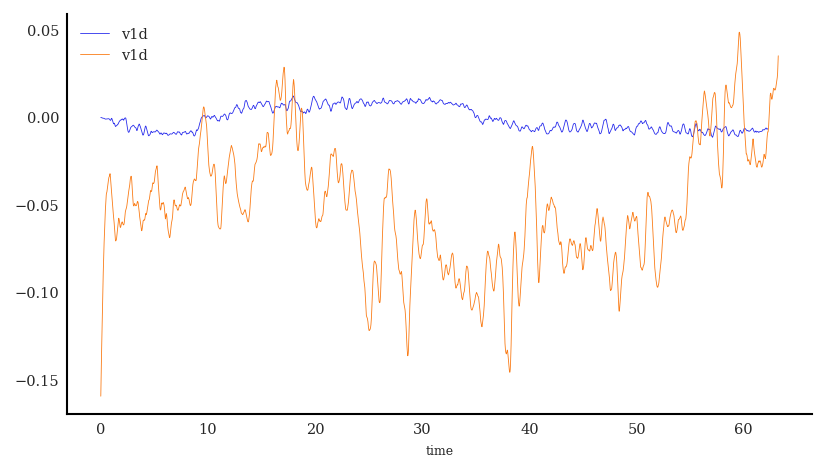

In [17]:
fig,ax=plt.subplots()
test.iloc[0:-100].plot(y=['v1d'], ax=ax)
df_acc.plot(y=['v1d'], ax=ax)

